In [1]:
import subprocess
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib import rc
import sympy
from sympy.printing.latex import LatexPrinter
import sys
import treelib
import networkx as nx
from prettytable import PrettyTable
import os

# sys.path.insert(0, '../generation/')
import esr.generation.simplifier as simplifier
import esr.generation.generator as generator

# sys.path.insert(0, '../fitting/')
import esr.fitting.test_all as test_all
import esr.fitting.fit_single as fit_single
from esr.fitting.sympy_symbols import *
from esr.fitting.likelihood import CCLikelihood, PanthLikelihood, MockLikelihood

rcParams['text.usetex'] = True

[MacBook-Pro-52.local:89070] shmem: mmap: an error occurred while determining whether or not /var/folders/73/51k60xm12sq1d8rpjhqrp9l80000gn/T//ompi.MacBook-Pro-52.501/jf.0/535363584/sm_segment.MacBook-Pro-52.501.1fe90000.0 could be created.


In [2]:
print('Making CC Likelihood')
cc_like = CCLikelihood()
print('Making Pantheon Likelihood')
panth_like = PanthLikelihood()

Making CC Likelihood
Making Pantheon Likelihood


# Figure 1 - Example function in tree representation

exp(a1*x) + Abs(log(x))**a0 ['exp(a1*x) + pow(Abs(log(x)),a0)']
$\left(\log\left(x\right)\right)^{\theta_0}+ \exp\left( \theta_1 x \right)$ = [${\rm +}$, ${\rm pow}$, ${\rm log}$, $x$, $\theta_{0}$, ${\rm exp}$, ${\rm *}$, $\theta_{1}$, $x$]


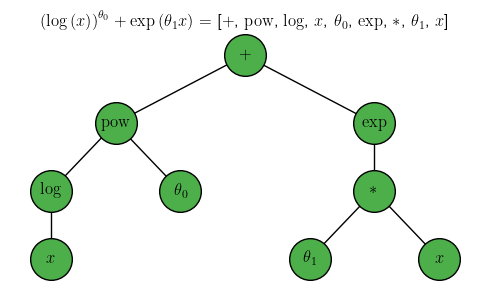

In [8]:
rcParams['text.usetex'] = True

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.
    Licensed under Creative Commons Attribution-Share Alike
    
    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    
def make_tree(tree, i, names):
    
    tree[i].tree = treelib.Tree()
    
    # Check for duplicate node names
    if tree[i].op in names:
        n = [a for a in names if a.startswith(tree[i].op)]
        tree[i].node_name = tree[i].op + str(len(n))
    else:
        tree[i].node_name = tree[i].op
    
    # Name and label of node
    if tree[i].val is None:
        tree[i].tree.create_node(tree[i].op, tree[i].node_name)
    else:
        tree[i].tree.create_node(str(tree[i].val), tree[i].node_name)
        
    # Store node names
    n2 = names.copy()
    n2 += [tree[i].node_name]
    
    if tree[i].type > 0:
        tree = make_tree(tree, tree[i].left, n2)
        n2 += list(tree[tree[i].left].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].left].tree)
    if tree[i].type > 1:
        tree = make_tree(tree, tree[i].right, n2)
        n2 += list(tree[tree[i].right].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].right].tree)
        
    return tree   

basis_functions = [["x", "a"],  # type0
                ["square", "exp", "inv", "sqrt", "log"],  # type1
                ["+", "*", "-", "/", "pow"]]  # type2

labels = ["+", "pow", "log", "x", "a0", "exp", "*", "a1", "x"]
tex_str = r'$\left(\log\left(x\right)\right)^{\theta_0}+ \exp\left( \theta_1 x \right)$'
s = []

for l in labels:
    if l.lstrip("-").isdigit() or (l.startswith('a') and l[1:].isdigit()):
        s.append(0)
    else:
        for i in range(len(basis_functions)):
            if l in basis_functions[i]:
                s.append(i)
                
success, part_considered, tree = generator.check_tree(s)
fstr = generator.node_to_string(0, tree, labels)
max_param = max(1, len([a for a in labels if a.startswith('a')]))
fstr, fsym = simplifier.initial_sympify([fstr], max_param, verbose=False)
fsym = fsym[fstr[0]]

print(fsym, fstr)

for i in range(len(tree)):
    tree[i].assign_op(labels[i])
    
make_tree(tree, 0, [])

G = nx.Graph()

# Add all nodes to graph
for n in list(tree[0].tree.nodes.keys()):
    G.add_node(n)

# Node labels
labs = {}
for k in tree[0].tree.nodes.keys():
    if k.startswith('a') and k[1:].isdigit():
        labs[k] = r'$\theta_{%s}$'%tree[0].tree.nodes[k].tag[1:]
    elif tree[0].tree.nodes[k].tag == 'x':
        labs[k] = r'$%s$'%tree[0].tree.nodes[k].tag
    elif '_' in k:
        i = k.index('_')
        labs[k] = r'${\rm %s\_%s}$'%(tree[0].tree.nodes[k].tag[:i], tree[0].tree.nodes[k].tag[i+1:])
    else:
        labs[k] = r'${\rm %s}$'%tree[0].tree.nodes[k].tag

# Add all edges to graph
if tree[0].tree.nodes:
    for n in tree[0].tree.expand_tree(mode=tree[0].tree.WIDTH):
        nid = tree[0].tree[n].identifier

        for c in tree[0].tree.children(nid):
            cid = c.identifier
            G.add_edge(nid, cid)

pos = hierarchy_pos(G, tree[0].tree.root)

cm = plt.get_cmap('Set1')

fig, ax = plt.subplots(1, 1, figsize=(5,3))
nx.draw(G, pos=pos,
        with_labels=True,
        labels=labs,
        node_size=900,
        node_color=cm(2),
        edgecolors='k')

t = [labs[a] for a in labels]
t = '[' + ', '.join(t) + ']'
t = r'%s'%t
t = tex_str + ' = ' + t
print(t)

ax.set_title(t)
fig.tight_layout()
fig.savefig('figs/tree.pdf', bbox_inches='tight', transparent=True)

# Figure 2 - Number of functions vs Complexity

167731333 1.68e+08
../function_library/core_maths/
1
2
3
4
5
6
7
8
9
10
1 2 2 1.0
2 2 2 1.0
3 22 13 1.6923076923076923
4 64 24 2.6666666666666665
5 598 131 4.564885496183206
6 2406 335 7.182089552238806
7 19860 1787 11.11359820928931
8 99406 5458 18.212898497618177
9 763765 28464 26.832665823496345
10 4339761 98018 44.275143341018996
Total: 5225886 134234 38.93116498055634 1249.5443255807024
Total with param: 4865011 119861 40.58877366282611 1399.3820592185948


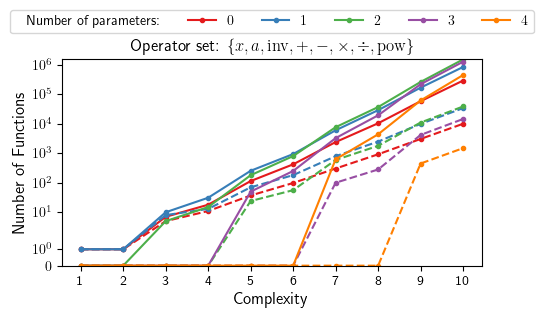

In [10]:
plot_unique = True

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE,
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])


def count_fun(fname):

    ntotal = file_len(fname)
    with open(fname, "r") as f:
        all_fun = f.read().splitlines()
    assert ntotal == len(all_fun), 'Maybe missing some equations'
    max_param = simplifier.get_max_param(all_fun, verbose=False)
    nparam = simplifier.count_params(all_fun, max_param)
    count = np.empty(max_param + 1, dtype=int)
    for i in range(len(count)):
        count[i] = (nparam == i).sum()
    assert ntotal == count.sum(), 'Count does not match total'

    return count

all_compl = np.arange(1, 11)
# all_compl = np.arange(1, 8)

dirname = '../function_library/core_maths/'
ops = r'$\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$'

basis_functions = [["x", "a"],  # type0
                    ["inv"],  # type1
                    ["+", "*", "-", "/", "pow"]]  # type2
nbasis = sum([len(b) for b in basis_functions])
nfun = sum([c ** nbasis for c in all_compl])
print(nfun, '%.2e'%nfun)

nfortab = 4

fig, axs = plt.subplots(1, 1, figsize=(5,3))
axs = [axs]
cm = plt.get_cmap('Set1')

axs[0].plot([], [], ' ', ms=0, label='Number of parameters:')

all_total = []
all_uniq = []

print(dirname)

for compl in all_compl:

    print(compl)

    try:
        fname = dirname + '/compl_%i/all_equations_%i.txt'%(compl,compl)
        total_count = count_fun(fname)

        fname = dirname + '/compl_%i/unique_equations_%i.txt'%(compl,compl)
        uniq_count = count_fun(fname)

        if (len(uniq_count) < nfortab+1) or (len(total_count) < nfortab+1):
            t = np.zeros(nfortab+1, dtype=int)
            t[:len(uniq_count)] = uniq_count
            uniq_count = t

            t = np.zeros(nfortab+1, dtype=int)
            t[:len(total_count)] = total_count
            total_count = t

        all_total.append([x for x in total_count[:nfortab+1]])
        all_uniq.append([x for x in uniq_count[:nfortab+1]])

    except:
        pass

all_total = np.array(all_total, dtype=int)
all_uniq = np.array(all_uniq, dtype=int)

for j in range(all_total.shape[1]):
    c = cm(j)
    axs[0].plot(all_compl[:all_total.shape[0]], all_total[:,j], color=c, marker='.', label=r'$%i$'%j)
    if plot_unique:
        axs[0].plot(all_compl[:all_total.shape[0]], all_uniq[:,j], color=c, ls='--', marker='.')

axs[0].set_xlabel('Complexity', fontsize=12)
axs[0].set_title('Operator set: %s'%ops)

axs[0].set_xticks(all_compl)
axs[0].set_xticklabels(all_compl)

for j, c in enumerate(all_compl[:all_total.shape[0]]):
    print(c, all_total[j].sum(), all_uniq[j].sum(), all_total[j].sum() / all_uniq[j].sum())
print('Total:', all_total.sum(), all_uniq.sum(), all_total.sum() / all_uniq.sum(), nfun / all_uniq.sum())
total_with_param = all_total[:,1:].sum()
uniq_with_param = all_uniq[:,1:].sum()
print('Total with param:', total_with_param, uniq_with_param, total_with_param / uniq_with_param, nfun / uniq_with_param)
    
axs[0].set_yscale('symlog')
axs[0].set_ylabel('Number of Functions', fontsize=12)
axs[0].set_ylim(0, None)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

leg = axs[int(np.floor(len(axs)/2))].legend(loc='upper center', 
                                            bbox_to_anchor=(0.5, 1.27), 
                                            ncol=nfortab+2, 
                                            fancybox=True)
lines = leg.get_lines()

for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

if plot_unique:
    fig.savefig('figs/count_functions.pdf', bbox_inches='tight', transparent=True)
else:
    fig.savefig('figs/count_functions_nounique.pdf', bbox_inches='tight', transparent=True)
# print(rcParams)

# Figures 3&4 - Data Comparison

In [12]:
def data_comparison(likelihood, all_compl, xplot, nfun, ylabel1, ylabel2, savename):

    tmax = 5
    
    likelihood.clear_data()

    # GET LCDM FUNCTION
    fcn_i = 'a0 * pow(x, 3) + a1'
    fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)

    if 'a3' in fcn_i:
        k = 4
        eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy"])
    elif 'a2' in fcn_i:
        k = 3
        eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy"])
    elif 'a1' in fcn_i:
        k = 2
        eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy"])
    elif 'a0' in fcn_i:
        k = 1
        eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy"])
    else:
        k = 0
        eq_numpy = sympy.lambdify([x], eq, modules=["numpy"])

    chi2, p = test_all.optimise_fun(fcn_i, likelihood, tmax, 0, 4, try_integration=False)
    print(chi2, p)

    likelihood.clear_data()
    ylcdm_var = likelihood.get_pred(likelihood.xvar, p[:k], eq_numpy, integrated=integrated)
    likelihood.clear_data()
    ylcdm_plot = likelihood.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

    # GET OTHER FUNCTIONS
    fcn_list = []
    all_DL = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = likelihood.out_dir + '/final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
        fcn_list += [d[1] for d in data]
        all_DL += [d[2] for d in data]
        params += [d[7:] for d in data]

    all_DL = np.array(all_DL, dtype=float)
    params = np.array(params, dtype=float)
    m = np.isfinite(all_DL)
    all_DL = all_DL[m]
    params = params[m,:]
    fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
    MDL = np.amin(all_DL)

    # Take top nfun functions
    idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
    all_DL = all_DL[idx] - MDL
    params = params[idx,:]
    fcn_list = [fcn_list[i] for i in idx]

    fig  = plt.figure(figsize=(5,4))
    ax1  = fig.add_axes([0.0,0.50,0.9,0.45])
    ax2  = fig.add_axes([0.0,0.0,0.9,0.45])
    ax3  = fig.add_axes([0.95,0.00,0.03,0.95])
    ax1.get_shared_x_axes().join(ax1, ax2)

    cmap = mpl.cm.hot
    vmin = all_DL.min()
    vmax = all_DL.max()    
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    print(all_DL.min(), all_DL.max())

    max_param = 4
    tmax = 5
    
    likelihood.clear_data()
    
    for i in range(len(fcn_list)):

        fcn_i = fcn_list[i].replace('\'', '')

        k = simplifier.count_params([fcn_i], max_param)[0]
        measured = params[i,:k]
        
#         if i%10 == 0:
#             print('%i of %i'%(i,len(fcn_list)))

        fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy"])
        ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)

        colour = cmap(norm(all_DL[i]))
        plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}

        ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
        ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)

    cmvar = plt.get_cmap('Set1')
    plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
                 'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}

    ax1.errorbar(likelihood.xvar-1, likelihood.yvar, yerr=likelihood.yerr, **plot_kwargs)
    ax2.errorbar(likelihood.xvar-1, likelihood.yvar-ylcdm_var, yerr=likelihood.yerr, **plot_kwargs)
    ax2.axhline(y=0, color=cmvar(1), ls='--')

    ax2.set_xlabel(r'$z$', fontsize=12)
    ax1.set_ylabel(ylabel1, fontsize=10)
    ax2.set_ylabel(ylabel2, fontsize=10)

    ax1.set_xlim(xplot.min()-1, xplot.max()-1)
    ax1.set_xscale('log')
    ax1.set_xticklabels([])

    cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(r'$L \left( D \right) - MDL$', fontsize=12)

    fig.align_ylabels([ax1, ax2])
    fig.tight_layout()

    ax1.get_yaxis().set_label_coords(-0.1,0.5)
    ax2.get_yaxis().set_label_coords(-0.1,0.5)

    fig.savefig(savename, bbox_inches='tight', transparent=True)
    
    return

data_comparison(cc_like, 
                np.arange(1, 11),
                np.logspace(np.log10(6e-2), np.log10(2.1), 1000) + 1,
                150, 
                r'$H \left( z \right) \ / \ {\rm km s^{-1} Mpc^{-1}}$', 
                r'$\left( H \left( z \right) - H_{\rm \Lambda CDM} \left( z \right) \right) \ / \ {\rm km s^{-1} Mpc^{-1}}$', 
                'figs/cc_prediction.pdf')

data_comparison(panth_like,
                np.arange(1, 11),
                np.logspace(np.log10(8e-3), np.log10(2.5), 1000) + 1,
                150, 
                r'$\mu \left( z \right)$', 
                r'$\mu \left( z \right) - \mu_{\rm \Lambda CDM} \left( z \right)$', 
                'figs/pantheon_prediction.pdf')


7.27709920851962 [1481.70888887 3164.01861191    0.            0.        ]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/giuliaborghetto/ESR/esr//fitting//output//output_cc_dimful/final_1.dat'

# Figure 5 - Pareto Front Comparison 


Max number of parameters: 2

Sympy simplify 2
theta_ML: [3164.02219976 1481.70861286    0.            0.        ]
Residuals: 7.2770992084799095 7.2770992084799095
Parameter: 3.7580181324718325
Function: 12.364677675706812

Description length: 23.399795016658555

Max number of parameters: 2

Sympy simplify 2
theta_ML: [3591.08656791 1773.6344123     0.            0.        ]
Residuals: 701.8518992969919 701.8518992969919
Parameter: 8.80644088879528
Function: 12.364677675706812

Description length: 723.0230178614939

DL
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ESR//fitting//output/output_cc_dimful/
44954 10455
LCDM CAME: 38
TWOCOMP CAME: 84
LCDM: 7.009691473318004 FLUID 8.67176134369815
4 53.002069701139014
5 0.0
6 7.219613531264052
7 4.209745184498683
8 7.3819443561322515
9 4.910550299999997
10 10.199190667858353

logL
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ESR//fitting//output/output_cc_dimful/
44954 9026
LCDM CAME: 846
TWOCOMP

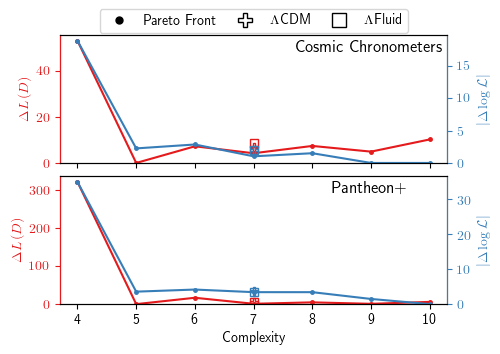

In [9]:
root_dirname = cc_like.like_dir + '/output/'
all_dirname = ['output_cc_dimful/', 'output_panth_dimful/']
line_labels = ['Cosmic Chronometers', 'Pantheon+']
all_dirname = [root_dirname + d for d in all_dirname]
all_all_compl = [np.arange(4, 11), np.arange(4, 11)]

all_twocomp_eq = ['a0 + a1*pow(x,a2)', 'a0 + a1*pow(x,a2)']
all_lcdm_eq = ['a0 + a1*x**3', 'a0 + a1*x**3']

fig, axs1 = plt.subplots(2, 1, figsize=(5,3.5), sharex=True)
axs2 = [ax.twinx() for ax in axs1]
cm = plt.get_cmap('Set1')
all_var_idx = [0, 2]

labels = ["+", "a0", "*", "a1", "pow", "x", "3"]
basis_functions = [["x", "a"],  # type0
                ["inv"],  # type1
                ["+", "*", "-", "/", "pow"]]  # type2
logl_lcdm_cc, dl_lcdm_cc = fit_single.single_function(labels, basis_functions, cc_like, verbose=True)
logl_lcdm_panth, dl_lcdm_panth = fit_single.single_function(labels, basis_functions, panth_like, verbose=True)
logl_lcdm7 = [logl_lcdm_cc, logl_lcdm_panth]
dl_lcdm7 = [dl_lcdm_cc, dl_lcdm_panth]
lcdm_complexity = len(labels)

for dirname in all_dirname:
    
    for var_idx in [0, 2]:
        
        if var_idx == 0:
            print('\nDL')
        else:
            print('\nlogL')
    
        print(dirname)

        twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
        lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
        all_compl = all_all_compl[all_dirname.index(dirname)]

        res = []
        fun = []
        params = []
        store_comp = []

        for i, compl in enumerate(all_compl):
            fname = dirname + 'final_%i.dat'%compl
            with open(fname, "r") as f:
                reader = csv.reader(f, delimiter=';')
                data = [row for row in reader]

                res += [d[2:7] for d in data]
                fun += [d[1] for d in data]
                params += [d[7:] for d in data]
                store_comp += [compl] * len(data)

        res = np.array(res, dtype=float)
        params = np.array(params, dtype=float)
        store_comp = np.array(store_comp, dtype=int)
        
        # Replace LCDM by complexity 7 version
        lcdm_idx = fun.index(lcdm_eq)
        if var_idx == 0:
            res[lcdm_idx,var_idx] = min(dl_lcdm7[all_dirname.index(dirname)],res[lcdm_idx,var_idx])
            store_comp[lcdm_idx] = lcdm_complexity   
        elif var_idx == 2:
            res[lcdm_idx,var_idx] = min(logl_lcdm7[all_dirname.index(dirname)],res[lcdm_idx,var_idx])
            store_comp[lcdm_idx] = lcdm_complexity  

        # Sort by DL
        m = np.argsort(res[:,var_idx], kind='stable')
        res = res[m,:]
        params = params[m,:]
        store_comp = store_comp[m]
        fun = [fun[i] for i in m]
        
        # Remove duplicates by likelihood
        _, uniq_idx = np.unique(res[:,2], return_index=True)
        uniq_idx = np.sort(uniq_idx)
        fun = [fun[i] for i in uniq_idx]
        res = res[uniq_idx,:]
        store_comp = store_comp[uniq_idx]
        params = params[uniq_idx,:]
        
        # Remove duplicates by name
        new_fun = []
        uniq_idx = []
        got_comp = [False]*(all_compl.max()+1)
        for i in range(len(fun)):
            if fun[i] not in new_fun:
                uniq_idx.append(i)
                new_fun.append(fun[i])
                got_comp[store_comp[i]] = True
                if all(got_comp[all_compl.min():all_compl.max()]) == True:
                    break
        print(len(fun), len(new_fun))
        fun = new_fun
        res = res[uniq_idx,:]
        store_comp = store_comp[uniq_idx]
        params = params[uniq_idx,:]

        twocomp_idx = fun.index(twocomp_eq)
        lcdm_idx = fun.index(lcdm_eq)
        
        # Print where LCDM and twocomp came
        print("LCDM CAME:", lcdm_idx+1)
        print("TWOCOMP CAME:", twocomp_idx+1)

        # Don't need to go higher than this
        idx = [store_comp.tolist().index(c) for c in all_compl]
        best_DL = [res[i,var_idx] for i in idx]
        lcdm_DL = res[lcdm_idx, var_idx]
        twocomp_DL = res[twocomp_idx, var_idx]
        
        # Subtract the best
        MDL = min(best_DL)
        best_DL = [d - MDL for d in best_DL]
        lcdm_DL -= MDL
        twocomp_DL -= MDL
        
        print("LCDM:", lcdm_DL, "FLUID", twocomp_DL)
        
        for i, c in enumerate(all_compl):
            print(c, best_DL[i])

        i = all_dirname.index(dirname)
        j = all_var_idx.index(var_idx)
        if j == 0:
            axs1[i].plot(all_compl, best_DL, marker='.', color=cm(j), markersize=5)
            axs1[i].plot(store_comp[lcdm_idx], lcdm_DL, 'P', color=cm(j), fillstyle='none')
            axs1[i].plot(store_comp[twocomp_idx], twocomp_DL, 's', color=cm(j), fillstyle='none')
        else:
            axs2[i].plot(all_compl, best_DL, marker='.', color=cm(j), markersize=5)
            axs2[i].plot(store_comp[lcdm_idx], lcdm_DL, 'P', color=cm(j), fillstyle='none')
            axs2[i].plot(store_comp[twocomp_idx], twocomp_DL, 's', color=cm(j), fillstyle='none')
            
for k in range(len(axs1)):
    axs1[k].set_ylabel(r'$\Delta L \left( D \right)$')
    axs2[k].set_ylabel(r'$ \left| \Delta \log\mathcal{L} \right|$')
    axs1[k].yaxis.label.set_color(cm(0))
    axs1[k].tick_params(axis='y', colors=cm(0))
    axs2[k].spines['left'].set_color(cm(0))

    axs2[k].yaxis.label.set_color(cm(1))
    axs2[k].tick_params(axis='y', colors=cm(1))
    axs2[k].spines['right'].set_color(cm(1))
    
    axs1[k].set_ylim(0, None)
    axs2[k].set_ylim(0, None)
    
    axs1[k].set_title(line_labels[k], x=0.80, y=0.80)
    
legend_elements = [Line2D([0], [0], marker='.', color='k', label=r'Pareto Front',
                      markerfacecolor='k', markersize=10, lw=0),
               Line2D([0], [0], marker='P', color='k', label=r'$\Lambda$CDM',
                      markerfacecolor='k', markersize=10, lw=0, fillstyle='none'),
              Line2D([0], [0], marker='s', color='k', label=r'$\Lambda$Fluid',
                      markerfacecolor='k', markersize=10, lw=0, fillstyle='none')]
axs1[0].legend(handles=legend_elements,
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.25), 
               ncol=len(legend_elements), 
               columnspacing=1)
                       
axs1[0].set_xticks(all_compl)
axs1[0].set_xticklabels(all_compl)
    
axs1[-1].set_xlabel(r'Complexity')

fig.subplots_adjust(hspace=0.1)
fig.savefig('figs/pareto_front.pdf', bbox_inches='tight', transparent=True)

# Tabulate the Best Functions

In [6]:
root_dirname = cc_like.like_dir + '/output/'
all_dirname = ['output_panth_dimful/', 'output_cc_dimful/']
all_dirname = [root_dirname + d for d in all_dirname]
all_all_compl = [np.arange(1, 11), np.arange(1, 11)]

Run this step by eye first to identify a Friedmann-like equation

In [23]:
nrow = 30

# select = 'CCPlus'  # CC + one fluid
# select = 'Single'  # Single component universe (not CC)
select = 'CCOnly'  # Just cosmological constant
# select = 'EdS'

if select == 'CCOnly':
    imax = -1
#     imax = 30000
elif select == 'EdS':
    imax =  -1
else:
    imax = 500

for j in range(len(all_dirname)):
    
    dirname = all_dirname[j]
    all_compl = all_all_compl[j]
    
    print('\n', dirname)
    fun = []
    DL = []
    LL = []
    params = []
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
            
            fun += [d[1] for d in data]
            DL += [d[2] for d in data]
            LL += [d[4] for d in data]
            params += [d[7:] for d in data]
    
    DL = np.array(DL, dtype=float)
    LL = np.array(LL, dtype=float)
    params = np.array(params, dtype=float)
    
    # Sort by DL
    m = np.argsort(DL, kind='stable')
    DL = DL[m]
    LL = LL[m]
    params = params[m,:]
    fun = [fun[i] for i in m]

    DL = DL[:imax]
    LL = LL[:imax]
    params = params[:imax,:]
    fun = fun[:imax]
    
    # Remove duplicates by likelihood
    _, uniq_idx = np.unique(LL, return_index=True)
    uniq_idx = np.sort(uniq_idx)
    fun = [fun[i] for i in uniq_idx]
    LL = LL[uniq_idx]
    DL = DL[uniq_idx]
    params = params[uniq_idx,:]
    
    # Remove duplicates
    new_fun = []
    uniq_idx = []
    for i in range(len(fun)):
        if fun[i] not in new_fun:
            uniq_idx.append(i)
            new_fun.append(fun[i])
    print(len(fun), len(new_fun))
    fun = new_fun
    DL = DL[uniq_idx]
    LL = LL[uniq_idx]
    params = params[uniq_idx,:]
            
    # Find best Friedmann-like equation
    if select == 'CCPlus':
        cand_idx = [i for i,f in enumerate(fun) if 'a2' in f and 'a3' not in f]
        cand_idx = [i for i in cand_idx if fun[i].count('pow') == 1 and 'pow(x,' in fun[i]]
        cand_idx = [i for i in cand_idx if 'pow(x,x)' not in fun[i]]
    elif select == 'Single':
        cand_idx = [i for i,f in enumerate(fun) if 'a2' not in f]
        cand_idx = [i for i in cand_idx if 'pow(x,x)' not in fun[i]]
    elif select == 'CCOnly':
        cand_idx = [i for i,f in enumerate(fun) if 'x' not in f]
    elif select == 'EdS':
        cand_idx = [i for i,f in enumerate(fun) if 'x**3' in fun[i]]
#         cand_idx = [i for i,f in enumerate(fun) if 'a0' in f and 'a1' not in f]
#         cand_idx = [i for i in cand_idx if 'pow(x,x)' not in fun[i]]
        
        
    DL = DL[cand_idx]
    LL = LL[cand_idx]
    params = params[cand_idx,:]
    fun = [fun[i] for i in cand_idx]

    ptab = PrettyTable()
    ptab.field_names = ["Rank", "Function", "DL", "LL", "a0", "a1", "a2"]
    
    for i in range(min(len(fun),nrow)):
        ptab.add_row([cand_idx[i]+1, fun[i], '%.2f'%DL[i], '%.2f'%LL[i], '%.2f'%params[i,0], '%.2f'%params[i,1], '%.2f'%params[i,2]])
     
    print(ptab)



 /mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ExhaustiveSR//fitting//output/output_panth_dimful/
42282 40305
+------+----------+----+----+----+----+----+
| Rank | Function | DL | LL | a0 | a1 | a2 |
+------+----------+----+----+----+----+----+
+------+----------+----+----+----+----+----+

 /mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ExhaustiveSR//fitting//output/output_cc_dimful/
44954 43264
+-------+---------------------------------+--------+--------+----------+----------+-------+
|  Rank |             Function            |   DL   |   LL   |    a0    |    a1    |   a2  |
+-------+---------------------------------+--------+--------+----------+----------+-------+
| 10058 |                a0               | 63.85  | 61.35  | 7548.52  |   0.00   |  0.00 |
| 15186 | 1/(-a2 + pow(Abs(a0),(a1 - 1))) | 113.93 | 61.35  |  -1.06   |   3.81   |  1.19 |
| 16403 |  -a2 + pow(Abs(a0),(1 - 1/a1))  | 160.34 | 138.80 | -3878.73 | -3767.38 |  0.00 |
| 1

In [13]:
all_twocomp_eq = ['a0 + a1*pow(x,a2)', 'a0 + a1*pow(x,a2)']
all_lcdm_eq = ['a0 + a1*x**3', 'a0 + a1*x**3']

## Sort by DL

In [15]:
nrow = 5
npcol = 3
all_res_file = ['tab_cc.txt', 'tab_panth.txt']
z = sympy.symbols('z', positive=True)

def process_fun(i):
    
    fcn_i = fun[i]
    fcn_i = fcn_i.replace('\n', '')
    fcn_i = fcn_i.replace('\'', '')

    eq = sympy.sympify(fcn_i,
                    locals={"inv": inv,
                            "square": square,
                            "cube": cube,
                            "sqrt": sqrt,
                            "log": log,
                            "pow": pow,
                            "x": x,
                            "a0": a0,
                            "a1": a1,
                            "a2": a2})
    f = texprinter.doprint(eq)
    f = '$' + f.replace('a_', '\\theta_') + '$'

    if 'a3' in fcn_i:
        npar = 4
    elif 'a2' in fcn_i:
        npar = 3
    elif 'a1' in fcn_i:
        npar = 2
    elif 'a0' in fcn_i:
        npar = 1
    else:
        npar = 0

    if npar > npcol:
        print('NOT ENOUGH COLUMNS FOR NUMBER OF PARAMETERS')

    s = ''
    for j in range(len(params[i,:])):
        if j < npar:
            if params[i,j] >= 0.01:
                s += '%.2f & '%params[i,j]
            else:
                a = '%.2e'%params[i,j]
                b = a[:a.index('e')]
                a = int(a[a.index('e')+1:])
                a = '$ %s \\times 10^{%s} $'%(b,a)
                s += a + ' & '
        else:
            s += '- & '
    s = s[:-2]
#     s = '\t\t\t%i & %s & %.2f & %.2f & %s \\\\'%(i+1, f, DL[i], logL[i], s)
#     sub = (i+1, f, store_comp[i], res[i,0], res[i,2], res[i,4], npar*np.log(2), res[i,3]-npar*np.log(2), s)
#     s = '\t\t\t%i & %s & %i & %.2f & %.2f & %.2f & %.2f & %.2f & %s \\\\'%sub

    sub = (i+1, f, store_comp[i], s, res[i,2], res[i,4], res[i,3], res[i,0])
    s = '\t\t\t%i & %s & %i & %s & %.2f & %.2f & %.2f & %.2f \\\\'%sub
    
    return s


for dirname in all_dirname:
    
    print(dirname)
    
    twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
    lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
    all_compl = all_all_compl[all_dirname.index(dirname)]

    res = []
    fun = []
    params = []
    store_comp = []
    
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            res += [d[2:7] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]
            store_comp += [compl] * len(data)

    res = np.array(res, dtype=float)
    params = np.array(params, dtype=float)
    store_comp = np.array(store_comp, dtype=int)
    
    params = params[:,:npcol]

    # Sort by DL
    m = np.argsort(res[:,0], kind='stable')
    res = res[m,:]
    params = params[m,:]
    store_comp = store_comp[m]
    fun = [fun[i] for i in m]

    twocomp_idx = fun.index(twocomp_eq)
    lcdm_idx = fun.index(lcdm_eq)
    
    # Don't need to go higher than this
    imax = max(lcdm_idx+1, nrow+1, twocomp_idx+1)
    res = res[:imax,:]
    params = params[:imax,:]
    store_comp = store_comp[:imax]
    fun = fun[:imax]
    
    # Remove duplicates by likelihood
    _, uniq_idx = np.unique(res[:,2], return_index=True)
    uniq_idx = np.sort(uniq_idx)
    fun = [fun[i] for i in uniq_idx]
    res = res[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    params = params[uniq_idx,:]
    
    # Remove duplicates
    new_fun = []
    uniq_idx = []
    for i in range(len(fun)):
        if fun[i] not in new_fun:
            uniq_idx.append(i)
            new_fun.append(fun[i])
    print(len(fun), len(new_fun))
    fun = new_fun
    res = res[uniq_idx,:]
    params = params[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    lcdm_idx = fun.index(lcdm_eq)
    twocomp_idx = fun.index(twocomp_eq)
    
    texprinter = LatexPrinter()

    form = 'c|c|c|c|c|c|c|c'
#     labs = 'Rank & Function & $L\\left(D\\right)$ & $-\\log\\mathcal{L}$'
#     labs = 'Rank & $y\\left( x \\right) \\ / \\ {\\rm km^2 s^{-2} Mpc^{-2}}$ & Complexity & $L\\left(D\\right)$ & $-\log\mathcal{L}$ & $k\\log n$ & $p \\log 2$ & $\sum_i L \\left( \\Delta_i \\right)$'
#     labs = 'Rank & $y\\left( x \\right)$ & Complexity & Description Length & Residuals & Function & Parameter'
#     labs = 'Rank & $y\\left( x \\right) \\ / \\ {\\rm km^2 s^{-2} Mpc^{-2}}$ & Complexity & $L\\left( D \\right)$ & Residuals$^1$ & Function$^2$ & Parameter$^3$'
    labs1 = '\\multirow{2}{*}{Rank} & \\multirow{2}{*}{$y\\left( x \\right) \\ / \\ {\\rm km^2 s^{-2} Mpc^{-2}}$} & \\multirow{2}{*}{Complexity} & \\multicolumn{%i}{c|}{Parameters} & \\multicolumn{4}{c|}{Codelength} \\\\'%params.shape[1] 
    labs2 = '& & '
    for i in range(params.shape[1]):
        form += '|c'
        labs2 += ' & $\\theta_{%i}$'%i
    labs2 += '& Residuals$^1$ & Function$^2$ & Parameter$^3$ & Total \\\\'

    print('\t\t\\begin{tabular}{%s}'%form)
    print('\t\t\\hline')
    print('\t\t' + labs1)
    print('\t\t\\rule{0pt}{3ex}')
    print('\t\t' + labs2)
    print('\t\t\\hline')

    for i in range(nrow):
        s = process_fun(i)
        print(s)
        
    for idx in np.sort([lcdm_idx, twocomp_idx]):

        if idx >= nrow:

            if idx > nrow:
                filler = '\\vdots & \\vdots & \\vdots & \\vdots & \\vdots & \\vdots & \\vdots'
                for i in range(params.shape[1]):
                    filler += ' & \\vdots'
                filler += ' \\\\'
                print(filler)

            s = process_fun(idx)
            print(s)

    print('\t\t\\hline') 
    print('\t\t\\end{tabular}')
    
    print('\t\t\\begin{tabular}{c}')
    print('\t\t\t $^1 - \\log\\mathcal{L} ( \\hat{\\bm{\\theta}} ) $ \\qquad\\qquad $^2 k\\log(n) + \\sum_j \\log(c_j)$ \\qquad\\qquad $^3 - \\frac{p}{2} \\log(3) + \\sum_i^p (\\log(I_{ii})^{1/2} + \\log(|\\hat{\\theta}_i|))$ \\')
    print('\t\t\\end{tabular}')

    print('\n\n')


/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ExhaustiveSR//fitting//output/output_panth_dimful/
96 96
		\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c}
		\hline
		\multirow{2}{*}{Rank} & \multirow{2}{*}{$y\left( x \right) \ / \ {\rm km^2 s^{-2} Mpc^{-2}}$} & \multirow{2}{*}{Complexity} & \multicolumn{3}{c|}{Parameters} & \multicolumn{4}{c|}{Codelength} \\
		\rule{0pt}{3ex}
		& &  & $\theta_{0}$ & $\theta_{1}$ & $\theta_{2}$& Residuals$^1$ & Function$^2$ & Parameter$^3$ & Total \\
		\hline
			1 & $\theta_{0} x^{x}$ & 5 & 5345.02 & - & -  & 706.18 & 6.93 & 5.11 & 718.22 \\
			2 & $\left|{\theta_{0}}\right|^{x^{\theta_{1}}}$ & 9 & 5280.11 & 0.16 & -  & 705.11 & 5.49 & 8.41 & 719.01 \\
			3 & $\theta_{0} \left|{\theta_{1}}\right|^{- x}$ & 5 & 1694.95 & 0.32 & -  & 701.79 & 6.93 & 10.33 & 719.05 \\
			4 & $\theta_{0} x^{x^{\theta_{1}}}$ & 7 & 5378.69 & 0.78 & -  & 702.45 & 9.70 & 6.98 & 719.13 \\
			5 & $\left|{\theta_{0}}\right|^{\left|{\theta_{1}}\right|^{x}}$ & 5 & 1898.47

## Sort by DL by easier visualisation

In [18]:
nrow = 10

for dirname in all_dirname:
    
    print(dirname)
    
    lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
    twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
    all_compl = all_all_compl[all_dirname.index(dirname)]

    res = []
    fun = []
    params = []
    store_comp = []
    
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            res += [d[2:7] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]
            store_comp += [compl] * len(data)

    res = np.array(res, dtype=float)
    params = np.array(params, dtype=float)
    store_comp = np.array(store_comp, dtype=int)
    
    params = params[:,:npcol]

    # Sort by DL
    m = np.argsort(res[:,0], kind='stable')
    res = res[m,:]
    params = params[m,:]
    store_comp = store_comp[m]
    fun = [fun[i] for i in m]
    lcdm_idx = fun.index(lcdm_eq)
    twocomp_idx = fun.index(twocomp_eq)
    
    # Don't need to go higher than this
    imax = max(lcdm_idx+1, nrow+1, twocomp_idx+1)
    res = res[:imax,:]
    params = params[:imax,:]
    store_comp = store_comp[:imax]
    fun = fun[:imax]
    
    # Remove duplicates by likelihood
    _, uniq_idx = np.unique(res[:,2], return_index=True)
    uniq_idx = np.sort(uniq_idx)
    fun = [fun[i] for i in uniq_idx]
    res = res[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    params = params[uniq_idx,:]
    
    # Remove duplicates
    new_fun = []
    uniq_idx = []
    for i in range(len(fun)):
        if fun[i] not in new_fun:
            uniq_idx.append(i)
            new_fun.append(fun[i])
    print(len(fun), len(new_fun))
    fun = new_fun
    res = res[uniq_idx,:]
    params = params[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    lcdm_idx = fun.index(lcdm_eq)
    twocomp_idx = fun.index(twocomp_eq)
    
    print('LCDM:', lcdm_idx)
    
    ptab = PrettyTable()
    ptab.field_names = ["Rank", "Function", "Complexity", "DL", "a0", "a1", "a2"]
    
    for i in range(nrow):
        ptab.add_row([i+1, fun[i], store_comp[i], '%.2f'%res[i,0], '%.2f'%params[i,0], '%.2f'%params[i,1], '%.2f'%params[i,2]])
        
    for idx in np.sort([lcdm_idx, twocomp_idx]):
        if idx >= nrow:

            if idx > nrow:
                ptab.add_row(['-' for _ in range(len(ptab.field_names))])
            ptab.add_row([idx+1, fun[idx], store_comp[idx], '%.2f'%res[idx,0], '%.2f'%params[idx,0], '%.2f'%params[idx,1], '%.2f'%params[idx,2]])
    
    print(ptab)

    
    

/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ExhaustiveSR//fitting//output/output_panth_dimful/
96 96
LCDM: 36
+------+--------------------------------+------------+--------+---------+---------+------+
| Rank |            Function            | Complexity |   DL   |    a0   |    a1   |  a2  |
+------+--------------------------------+------------+--------+---------+---------+------+
|  1   |          a0*pow(x,x)           |     5      | 718.22 | 5345.02 |   0.00  | 0.00 |
|  2   |    pow(Abs(a0),(pow(x,a1)))    |     9      | 719.01 | 5280.11 |   0.16  | 0.00 |
|  3   |       a0/pow(Abs(a1),x)        |     5      | 719.05 | 1694.95 |   0.32  | 0.00 |
|  4   |     a0*pow(x,(pow(x,a1)))      |     7      | 719.13 | 5378.69 |   0.78  | 0.00 |
|  5   | pow(Abs(a0),(pow(Abs(a1),x)))  |     5      | 720.02 | 1898.47 |   1.14  | 0.00 |
|  6   | a0*pow(x,(pow(x,(pow(x,a1))))) |     9      | 720.29 | 5367.45 |  -0.43  | 0.00 |
|  7   |   a0*pow(x,(pow(Abs(a1),x)))   |     

## Sort by likelihood

In [17]:
nrow = 10

for dirname in all_dirname:
    
    print(dirname)
    
    lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
    twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
    all_compl = all_all_compl[all_dirname.index(dirname)]

    res = []
    fun = []
    params = []
    store_comp = []
    
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]

            res += [d[2:7] for d in data]
            fun += [d[1] for d in data]
            params += [d[7:] for d in data]
            store_comp += [compl] * len(data)

    res = np.array(res, dtype=float)
    params = np.array(params, dtype=float)
    store_comp = np.array(store_comp, dtype=int)
    
    params = params[:,:npcol]

    # Sort by LL
    m = np.argsort(res[:,2], kind='stable')
    res = res[m,:]
    params = params[m,:]
    store_comp = store_comp[m]
    fun = [fun[i] for i in m]
    lcdm_idx = fun.index(lcdm_eq)
    twocomp_idx = fun.index(twocomp_eq)
    print('LCDM:', lcdm_idx)
    
    # Don't need to go higher than this
    imax = max(lcdm_idx+1, nrow+1, twocomp_idx+1)
    res = res[:imax,:]
    params = params[:imax,:]
    store_comp = store_comp[:imax]
    fun = fun[:imax]
    
    # Remove duplicates by likelihood
    _, uniq_idx = np.unique(res[:,2], return_index=True)
    uniq_idx = np.sort(uniq_idx)
    fun = [fun[i] for i in uniq_idx]
    res = res[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    params = params[uniq_idx,:]
    
    # Remove duplicates
    new_fun = []
    uniq_idx = []
    for i in range(len(fun)):
        if fun[i] not in new_fun:
            uniq_idx.append(i)
            new_fun.append(fun[i])
    print(len(fun), len(new_fun))
    fun = new_fun
    res = res[uniq_idx,:]
    params = params[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    lcdm_idx = fun.index(lcdm_eq)
    twocomp_idx = fun.index(twocomp_eq)
    
    ptab = PrettyTable()
    ptab.field_names = ["Rank", "Function", "Complexity", "-logL", "a0", "a1", "a2"]
    
    for i in range(nrow):
        ptab.add_row([i+1, fun[i], store_comp[i], '%.2f'%res[i,2], '%.2f'%params[i,0], '%.2f'%params[i,1], '%.2f'%params[i,2]])
        
    for idx in np.sort([lcdm_idx, twocomp_idx]):
        if idx >= nrow:

            if idx > nrow:
                ptab.add_row(['-' for _ in range(len(ptab.field_names))])
            ptab.add_row([idx+1, fun[idx], store_comp[idx], '%.2f'%res[idx,2], '%.2f'%params[idx,0], '%.2f'%params[idx,1], '%.2f'%params[idx,2]])
    
    print(ptab)

    
    

/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ExhaustiveSR//fitting//output/output_panth_dimful/
LCDM: 5116
2506 2393
+------+--------------------------------------------+------------+--------+---------+---------+----------+
| Rank |                  Function                  | Complexity | -logL  |    a0   |    a1   |    a2    |
+------+--------------------------------------------+------------+--------+---------+---------+----------+
|  1   | pow(Abs(a1 + 1/(a0 - x)),(pow(Abs(a2),x))) |     10     | 698.22 |   1.87  | 1788.46 |   1.15   |
|  2   |     pow(Abs(a0 - pow(x,a1)),(a2 - x))      |     9      | 699.70 |   0.34  | -362.14 |  -6.99   |
|  3   | pow(Abs(a0 - 1/(a1 - x)),(pow(Abs(a2),x))) |     10     | 700.18 | 1859.77 |   1.00  |   1.14   |
|  4   | pow(Abs(a0 + 1/(a1 + x)),(pow(Abs(a2),x))) |     10     | 700.25 | 1863.22 |  -1.00  |   1.14   |
|  5   |       -a2 + pow(Abs(a0*(a1 - x)),x)        |     9      | 701.37 |  601.39 |   2.02  | -4822.89 |
|  

# Mock Test

<ErrorbarContainer object of 3 artists>

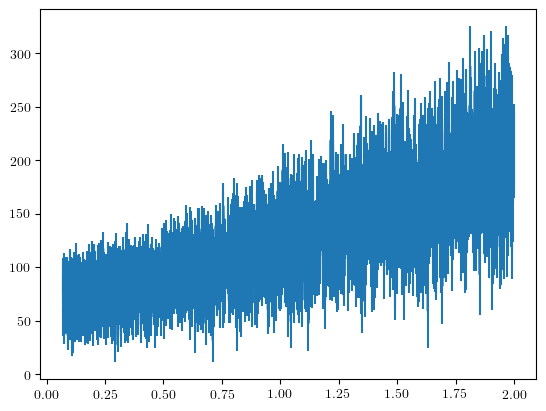

In [6]:
xvar, yvar, yerr = np.loadtxt('../data/mock/CC_Hubble_3200_0.2.dat', unpack=True)
xvar += 1
cmvar = plt.get_cmap('Set1')
plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
                 'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}
plt.errorbar(xvar-1, yvar, yerr=yerr)

In [28]:
yfracerr = 0.05
# yfracerr = 0.2
nz = 3200; all_compl = np.arange(1, 10)
# nz = 800; all_compl = np.arange(1, 10)

nrow = 10
npcol = 3

dirname = '../fitting/output/output_mock_%i_'%nz + str(yfracerr) + '/'
    
print(dirname)

# lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
# twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
# all_compl = all_all_compl[all_dirname.index(dirname)]

res = []
fun = []
params = []
store_comp = []

for i, compl in enumerate(all_compl):
    fname = dirname + 'final_%i.dat'%compl
    with open(fname, "r") as f:
        reader = csv.reader(f, delimiter=';')
        data = [row for row in reader]

        res += [d[2:7] for d in data]
        fun += [d[1] for d in data]
        params += [d[7:] for d in data]
        store_comp += [compl] * len(data)

res = np.array(res, dtype=float)
params = np.array(params, dtype=float)
store_comp = np.array(store_comp, dtype=int)

params = params[:,:npcol]

# Sort by DL
m = np.argsort(res[:,0], kind='stable')
res = res[m,:]
params = params[m,:]
store_comp = store_comp[m]
fun = [fun[i] for i in m]
# lcdm_idx = fun.index(lcdm_eq)
# twocomp_idx = fun.index(twocomp_eq)
# print('LCDM:', lcdm_idx)

# # Don't need to go higher than this
# imax = max(lcdm_idx+1, nrow+1, twocomp_idx+1)
imax = 100
res = res[:imax,:]
params = params[:imax,:]
store_comp = store_comp[:imax]
fun = fun[:imax]

# Remove duplicates by likelihood
_, uniq_idx = np.unique(res[:,2], return_index=True)
uniq_idx = np.sort(uniq_idx)
fun = [fun[i] for i in uniq_idx]
res = res[uniq_idx,:]
store_comp = store_comp[uniq_idx]
params = params[uniq_idx,:]

# Remove duplicates
new_fun = []
uniq_idx = []
for i in range(len(fun)):
    if fun[i] not in new_fun:
        uniq_idx.append(i)
        new_fun.append(fun[i])
print(len(fun), len(new_fun))
fun = new_fun
res = res[uniq_idx,:]
params = params[uniq_idx,:]
store_comp = store_comp[uniq_idx]
# lcdm_idx = fun.index(lcdm_eq)
# twocomp_idx = fun.index(twocomp_eq)

ptab = PrettyTable()
ptab.field_names = ["Rank", "Function", "Complexity", "DL", "a0", "a1", "a2"]

for i in range(nrow):
    ptab.add_row([i+1, fun[i], store_comp[i], '%.2f'%res[i,0], '%.2f'%params[i,0], '%.2f'%params[i,1], '%.2f'%params[i,2]])

# for idx in np.sort([lcdm_idx, twocomp_idx]):
#     if idx >= nrow:

#         if idx > nrow:
#             ptab.add_row(['-' for _ in range(len(ptab.field_names))])
#         ptab.add_row([idx+1, fun[idx], store_comp[idx], '%.2f'%res[idx,0], '%.2f'%params[idx,0], '%.2f'%params[idx,1], '%.2f'%params[idx,2]])

print(ptab)




../fitting/output/output_mock_3200_0.05/
30 30
+------+--------------------------------------------------+------------+---------+---------+----------+------+
| Rank |                     Function                     | Complexity |    DL   |    a0   |    a1    |  a2  |
+------+--------------------------------------------------+------------+---------+---------+----------+------+
|  1   |                   a0 + a1*x**3                   |     9      | 1617.08 | 3116.79 | 1432.34  | 0.00 |
|  2   |          a0*pow(x,(pow(x,(pow(x,a1)))))          |     9      | 1620.37 | 4504.06 |  -0.40   | 0.00 |
|  3   |       a0/pow(Abs(a1),(pow(Abs(a2),(1/x))))       |     8      | 1622.04 | 3435.57 |   0.00   | 0.04 |
|  4   |                a0 + a1*pow(x,a2)                 |     7      | 1622.08 | 3098.14 | 1444.05  | 2.99 |
|  5   |       a0*pow(x,(pow(x,(pow(Abs(a1),x)))))        |     9      | 1623.06 | 4543.69 |   0.86   | 0.00 |
|  6   |             a0 - a1*(-x + pow(x,a2))             |     9

Find when the Friedmann would be discovered

Running: 0.01
../fitting/output/output_mock_3200_0.01/


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

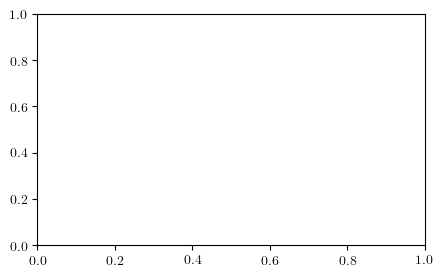

In [4]:
yfracerr = 0.1
# nz = 3200; all_compl = np.arange(1, 11)
nz = 3200; all_compl = np.arange(1, 11)
imax = 1000
lcdm_eq = 'a0 + a1*x**3'
# all_new_z = [1800, 2100, 2400, 2700, 3000, 3200, 3500, 3800, 4100]
# all_new_z = np.linspace(30, 3500, 30)
all_new_z = np.logspace(np.log10(10), np.log10(5000), 500)

all_yfracerr = [0.01, 0.05, 0.1, 0.2]

cm = plt.get_cmap('Set1')

fig, ax = plt.subplots(1, 1, figsize=(5,3))

for yfracerr in all_yfracerr:
    
    print('Running:', yfracerr)

    # (1) Load the data
    dirname = '../fitting/output/output_mock_%i_'%nz + str(yfracerr) + '/'
    print(dirname)
    res = []
    fun = []
    params = []
    store_comp = []
    for i, compl in enumerate(all_compl):
        fname = dirname + 'final_%i.dat'%compl
        if os.path.isfile(fname):
            with open(fname, "r") as f:
                reader = csv.reader(f, delimiter=';')
                data = [row for row in reader]

                res += [d[2:7] for d in data]
                fun += [d[1] for d in data]
                params += [d[7:] for d in data]
                store_comp += [compl] * len(data)
    res = np.array(res, dtype=float)
    params = np.array(params, dtype=float)
    store_comp = np.array(store_comp, dtype=int)

    # (2) Remove low-ranked functions and sort data
    m = np.argsort(res[:,0], kind='stable')
    res = res[m,:]
    params = params[m,:]
    store_comp = store_comp[m]
    fun = [fun[i] for i in m]
    res = res[:imax,:]
    params = params[:imax,:]
    store_comp = store_comp[:imax]
    fun = fun[:imax]
    
    # (3) Remove duplicates by likelihood
    _, uniq_idx = np.unique(res[:,2], return_index=True)
    uniq_idx = np.sort(uniq_idx)
    fun = [fun[i] for i in uniq_idx]
    res = res[uniq_idx,:]
    store_comp = store_comp[uniq_idx]
    params = params[uniq_idx,:]

    # (4) Remove duplicates by name
    new_fun = []
    uniq_idx = []
    for i in range(len(fun)):
        if fun[i] not in new_fun:
            uniq_idx.append(i)
            new_fun.append(fun[i])
    print(len(fun), len(new_fun))
    fun = new_fun
    res = res[uniq_idx,:]
    params = params[uniq_idx,:]
    store_comp = store_comp[uniq_idx]

    # (5) Separate into separate parts
    m = params!=0
    p = np.sum(m, axis=1)
    p_term = -p/2 * np.log(3)  # -p/2 log(3)
    logtheta = params.copy()
    logtheta[~m] = 1  # so do log(1)=0 when no parameter 
    logtheta = np.log(np.abs(logtheta))
    logtheta = np.sum(logtheta, axis=1)  # sum_i log(theta_i)
    fish_term = res[:,3] - logtheta - p_term
    logL = res[:,2]
    functional = res[:,4]

    def get_delta_DL(new_nz):
        DL = (new_nz / nz) * logL + p/2 * np.log(new_nz / nz) + res[:,4] + res[:,3]
        m = np.argsort(DL, kind='stable')
        f0, f1 = fun[m[0]], fun[m[1]]
        DL0, DL1 = DL[m[:2]]
        if f0 == lcdm_eq:
            toptwo = True
            DL = DL1 - DL0
        elif f1 == lcdm_eq:
            toptwo = True
            DL = DL0 - DL1
        else:
            toptwo = False
            i = list(m).index(0)
            DL = DL0 - DL[0]
        return toptwo, DL


    all_DL = np.empty(len(all_new_z))
    all_toptwo = np.zeros(len(all_new_z), dtype=bool)
    for i, new_nz in enumerate(all_new_z):
        all_toptwo[i], all_DL[i] = get_delta_DL(new_nz)

    label = r'$\sigma_H / H = %.2f$'%(yfracerr)
    c = cm(all_yfracerr.index(yfracerr))
    if np.all(all_toptwo):
        ax.plot(all_new_z, all_DL, color=c, label=label)
    else:
        m = list(all_toptwo.astype(int)).index(1)
        ax.plot(all_new_z[:m+1], all_DL[:m+1], ls='--', color=c)
        ax.plot(all_new_z[m:], all_DL[m:], ls='-', color=c, label=label)
    
ax.axhline(y=0, color='k')
ax.set_xlabel(r'Number of Cosmic Chrometers')
ax.set_ylabel(r'(Predicted) Preference for $\Lambda$CDM [$\Delta DL$]')
ax.set_xscale('log')
ax.legend()
fig.tight_layout()
fig.savefig('figs/mock_results.pdf', bbox_inches='tight', transparent=True)
